```
Print file contents and attributes:
h5dump -n 1 TEOB_dataI.hdf5

Copy data from vulcan:
gsiscp vulcan2.aei.mpg.de:/work/mpuer/projects/gpsurrogate/test_40Hz_1D/TEOB_dataI.hdf5 .

Try this for fitting out a line:
import scipy.signal as signal
signal.detrend(x)

Try a Hilbert transform for the Amplitude of the Fourier transform instead of a moving average. Maybe that will work better to low-pass filter and smooth the function ~A(f). Can also try it for ~Phi(f). It might avoid the bias that results from using too long of an averaging window.

Window out merger waveform as was done with SpinTaylorT4 if the surrogate looks terrible, to check that nothing in the inspiral is causing the surrogate problems.
```

In [1]:
%pylab inline
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib
matplotlib.__version__

'2.0.0rc1'

In [254]:
sys.path.insert(0, '../../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2
import gaussianprocessregression as gpr
import designofexperiment as doe
#import pycbcwaveform as pycbcwave
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics
import window
import trainingseteob as traineob
import hybrid

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(taylorf2)
imp.reload(gpr)
imp.reload(doe)
#imp.reload(pycbcwave)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)
imp.reload(window)
imp.reload(traineob)
imp.reload(hybrid)

import constants
imp.reload(constants)
from constants import *

In [5]:
from lalwaveform import dimensionless_td_waveform, dimensionless_fd_waveform
import pycbc.waveform

from scipy import stats
import h5py
import glob

# Methods for the training set

In [6]:
import h5py

def load_eob_training_set_td(orig_filename, mtot=2.0, distance=1.0):
    """Load a compressed waveform set and return a list of Waveform objects.
    """
    # Open original waveform file
    f = h5py.File(orig_filename)
    nwave = len(f['configurations'][:])
    print f.attrs['GenerationSettings']
    print f['configurations_keys'][:]
    print f['data_keys_name'][:]
    
    params = []
    hlist = []
    for i in range(nwave):
        print i, 
        try:
            p, h = traineob.get_waveform_from_training_set(f, i, mtot=mtot, distance=distance)
        except KeyError as e:
            print e
        else:
            # Run if an exception was not raised
            params.append(p)
            hlist.append(h)
        
    return np.array(params), hlist

# Load test waveforms

In [362]:
#orig_filename = '../../data/teobtest40hz/TEOB_data_train_corners_lhd.hdf5'
orig_filename = '../../data/teobtest40hz/TEOB_data_test2.hdf5'
params, hlist = load_eob_training_set_td(orig_filename)


        approximant = TEOBv4
        M = 2
        fs = 16384
        iota = 0
        f_min = 40
        distance = 1e+06

        Using lalsimulation version 1.7.0.1
        
['q' 'chi1' 'chi2' 'lambda1' 'lambda2']
['t' 'phi' 'amp']
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 21

(-1000, 200)

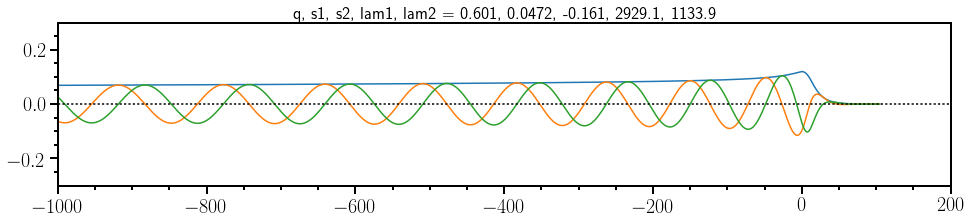

In [378]:
#i=125
i = 100
p = params[i]
h = hlist[i]
fig, ax = wave.plot_waveforms([h], hc=True, xi=-1000, xf=200, npoints=10000)
title = 'q, s1, s2, lam1, lam2 = {:.3}, {:.3}, {:.3}, {:.1f}, {:.1f}'.format(p[0], p[1], p[2], p[3], p[4])
ax.set_title(title)
ax.minorticks_on()
ax.set_ylim(-0.3, 0.3)
ax.set_xlim(-1000, 200)

In [364]:
Bamp_filename = '../../data/teobtest40hz/B_amp_lhd_uncsamp_rand.hdf5'
Bphase_filename = '../../data/teobtest40hz/B_phase_lhd_uncsamp_rand.hdf5'
gp_amp_filename = '../../data/teobtest40hz/gp_amp_lhd_uncsamp_rand.hdf5'
gp_phase_filename = '../../data/teobtest40hz/gp_phase_lhd_uncsamp_rand.hdf5'
sur = surrogate.GPSurrogate.load(Bamp_filename, Bphase_filename, gp_amp_filename, gp_phase_filename)

In [375]:
def geometric_time_domain_waveform(sur, p, delta_t=10.0, fwinf=None):
    """
    """
    # Evaluate frequency-domain waveform
    htilde = sur.geometric_waveform(p)
    
    # Number of samples needed (nsamp) and associated delta_f
    flow = htilde.x[0]
    fhigh = htilde.x[-1]
    q = p[0]
    min_total_time = 2.0*train.zero_pn_coalescence_time(flow, q)
    nsamp = train.next_pow_2(min_total_time, delta_t)
    delta_f = 1.0/(nsamp*delta_t)
    
    # Window beginning of waveform
    fwini = htilde.x[0]
    if fwinf is None:
        fwinf = 1.1*fwini
    
    htilde_win = window.window_on(htilde.copy(), fwini, fwinf, win='planck')
    
    ######## IFFT waveform ##########
    
    # Resample waveform to have spacing delta_f.
    # Pad beginning and end with zeros.
    fs = delta_f*np.arange(nsamp)
    htilde_comp = np.zeros(nsamp, dtype='complex')

    fresamp = fs[(fs>=flow) & (fs<=fhigh)]
    htilde_comp_resamp = htilde_win.interpolate_complex()(fresamp)
    
    ind_i = np.where(fs==fresamp[0])[0][0]
    ind_f = np.where(fs==fresamp[-1])[0][0]
    
    htilde_comp[ind_i:ind_f+1] = htilde_comp_resamp
    
    # Plot the padded waveform
#     hpad = wave.Waveform.from_complex(fs, htilde_comp)
#     fig, (ax1, ax2) = wave.plot_waveforms_fd([hpad])
#     #ax1.set_yscale('log')
#     ax1.set_ylabel(r'$A$')
#     ax2.set_ylabel(r'$\Phi$')
#     ax2.set_xlabel(r'$Mf$')
#     ax1.grid(which='both')
#     ax2.grid(which='both')
#     ax1.minorticks_on()
#     ax2.minorticks_on()
#     #ax1.set_ylim(1.0e-2, 1.0e4)
    
    # IFFT
    h_comp = np.fft.ifft(htilde_comp)
    ts = delta_t*np.arange(nsamp, dtype=float)

    # You didn't include the negative frequencies, 
    # so compensate by taking first half and adding to end of second half
    # !!!! Why don't you need to take the complex conjugate of the negative frequency part? !!!!
    h_comp_shift = np.concatenate((h_comp[nsamp//2:], h_comp[:nsamp//2]))
    h_comp_shift /= delta_t
    h = wave.Waveform.from_complex(ts, h_comp_shift)
    
    # Shift t=0 to time of max amplitude
    tmax = traineob.time_at_max_amp(h.x, h.amp)
    h.x -= tmax
    
    # Truncate waveform after t=500M
    tresamp = h.x[h.x<=500.]
    h.resample(tresamp)
    return h

[ 0.33333333 -0.4        -0.4         0.1         0.1       ]
-67.6020207371 -0.472838672479


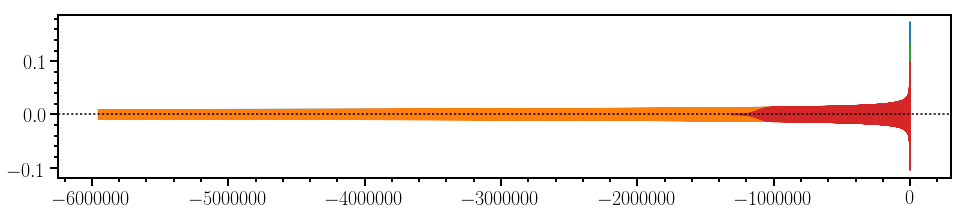

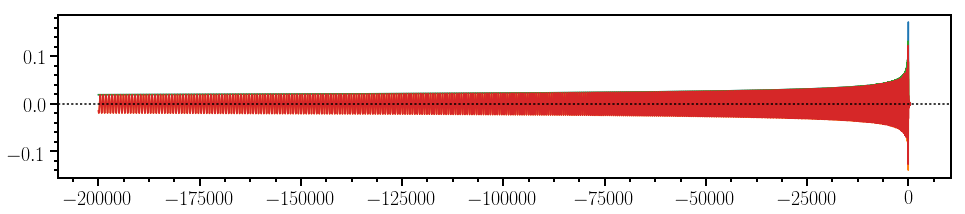

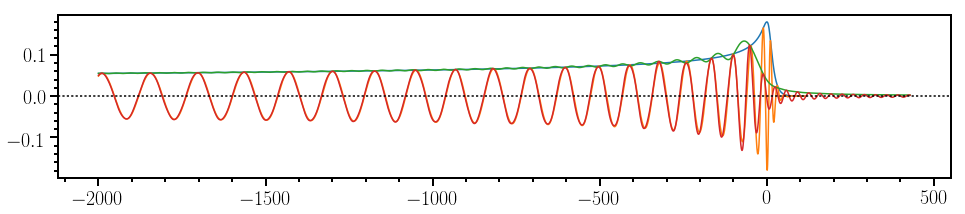

In [376]:
i = 0
p = params[i]
h = hlist[i]
print p

hsur_td = geometric_time_domain_waveform(sur, p, delta_t=10.)

h1 = h
h2 = hsur_td
# Often need really long window to get reliable overlap at low frequencies
t1i = -200000
t1f = -100000
taua = -500
taub = 500
taubest, phibest = hybrid.calculate_time_phase_shift(h1, h2, t1i, t1f, taua, taub)
print taubest, phibest
hsur_td.x += taubest
hsur_td.phase -= phibest


fig, ax = wave.plot_waveforms([h, hsur_td], npoints=100000)
ax.minorticks_on()
#ax.set_ylim(-0.3, 0.3)

fig, ax = wave.plot_waveforms([h, hsur_td], xi=t1i, xf=1000, npoints=10000)
ax.minorticks_on()
#ax.set_ylim(-0.3, 0.3)

fig, ax = wave.plot_waveforms([h, hsur_td], xi=-2000, xf=1000, npoints=10000)
ax.minorticks_on()
#ax.set_ylim(-0.3, 0.3)

[  7.72598277e-01   3.58441970e-01  -1.81498481e-01   9.30367830e+02
   1.53095699e+03]
-22.6727602835 2.44044959581
[  5.71896388e-01  -2.44673700e-01  -2.00727468e-01   2.75289039e+03
   2.26881782e+02]
-16.3318923803 -2.00927495984
[  5.31712176e-01   2.60857169e-01   1.61300043e-01   1.94993536e+03
   2.27609212e+03]
-15.0716634772 -1.59480896105
[  5.51420758e-01   8.47286931e-02   2.57530704e-01   1.32783602e+03
   2.19700924e+03]
-19.2324231904 2.69919156539
[  5.03512902e-01  -2.22339600e-01   3.25030561e-01   9.31822923e+02
   6.37369797e+02]
-18.1599773851 0.254123087172
[  9.66205044e-01   3.66783656e-02  -3.16441718e-01   1.11168475e+03
   1.55685785e+03]
-20.334119456 -0.739449898312
[  4.82061211e-01   3.24602237e-01   5.97838504e-02   2.85095605e+03
   1.00042327e+03]
-2.59182190272 1.00353821743
[  6.76131114e-01  -2.66796089e-01   1.82669104e-01   7.49050942e+02
   5.92667982e+02]
-23.2695707817 -3.02297571247
[  3.47439446e-01   1.54540856e-01  -3.16139255e-01   2.444

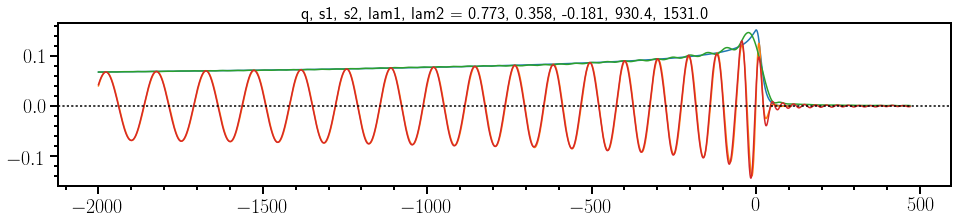

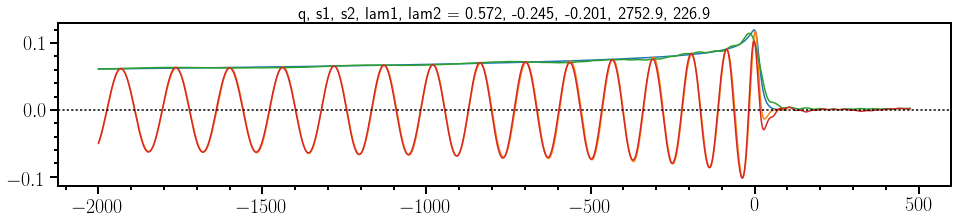

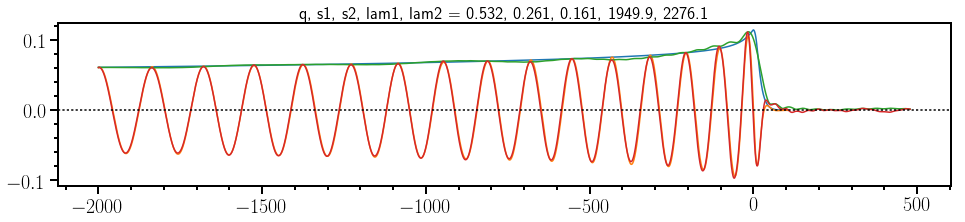

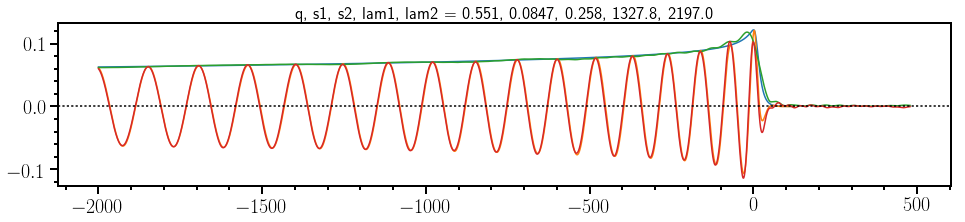

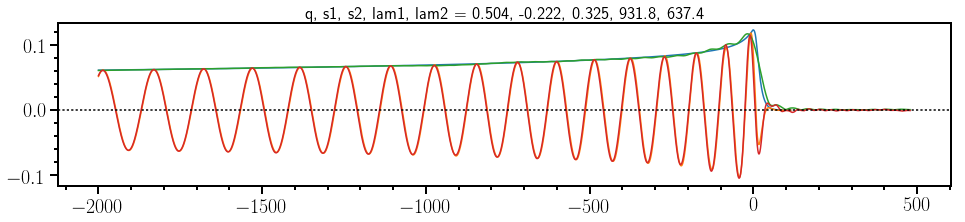

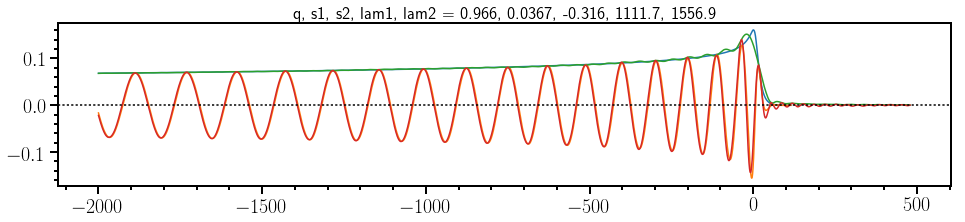

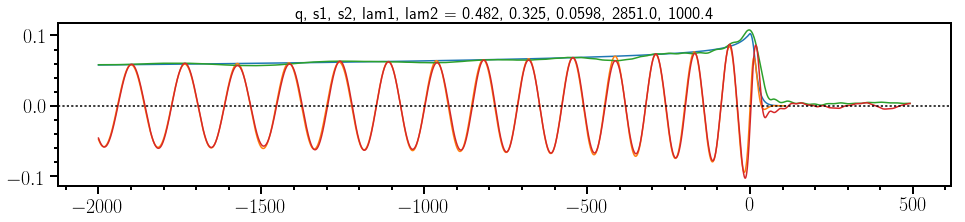

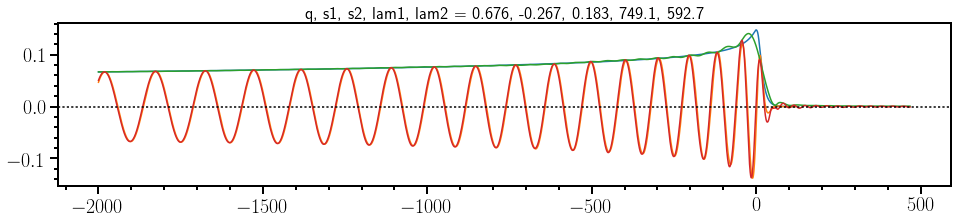

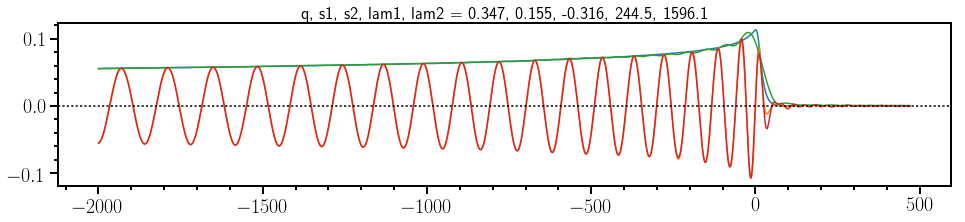

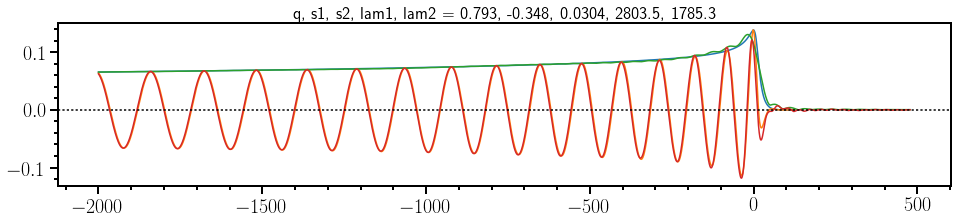

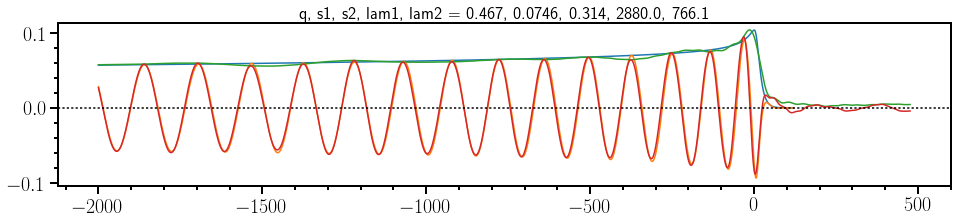

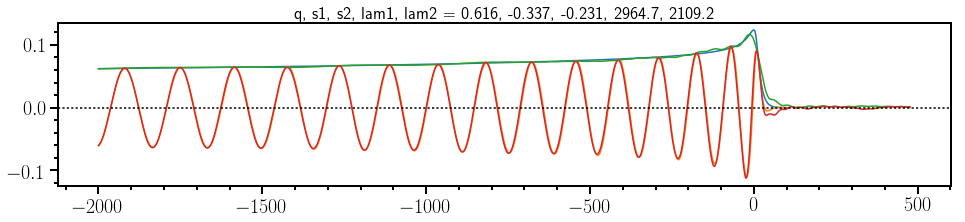

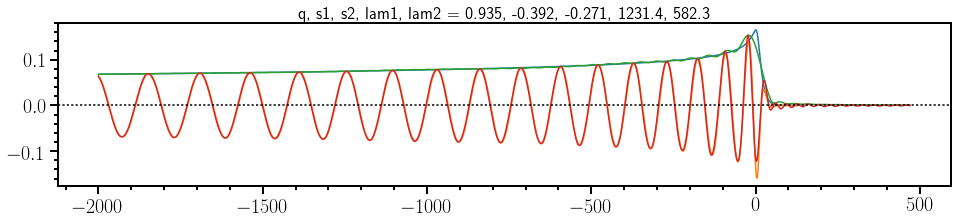

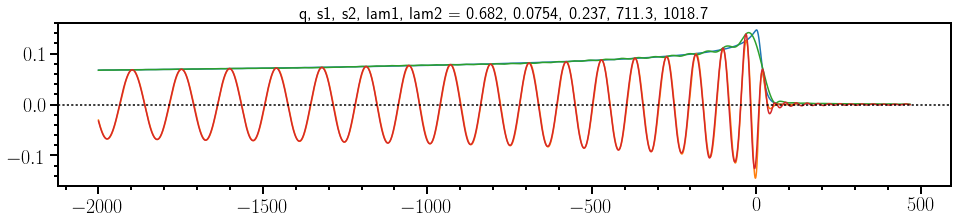

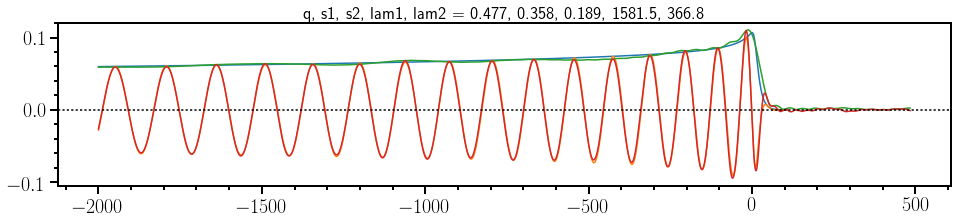

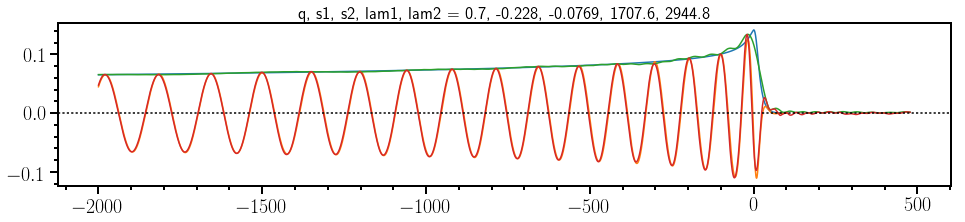

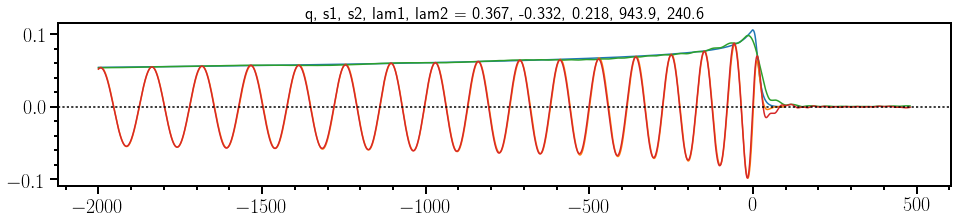

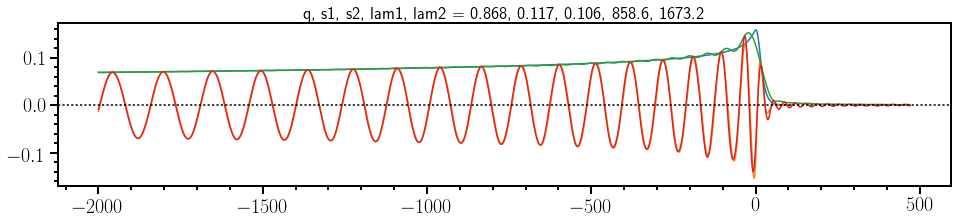

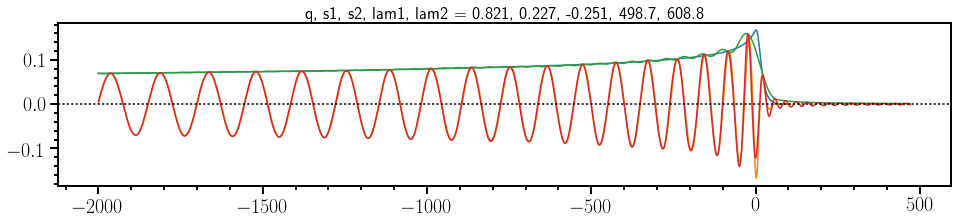

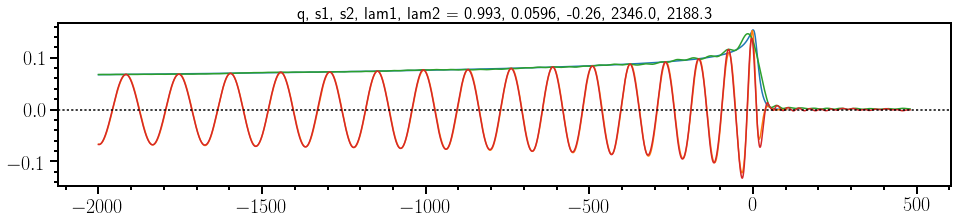

In [372]:
for i in range(20):
    p = params[i]
    h = hlist[i]
    print p

    hsur_td = geometric_time_domain_waveform(sur, p, delta_t=10.)
    
    h1 = h
    h2 = hsur_td
    # Often need really long window to get reliable overlap at low frequencies
    t1i = -200000
    t1f = -100000
    taua = -500
    taub = 500
    taubest, phibest = hybrid.calculate_time_phase_shift(h1, h2, t1i, t1f, taua, taub)
    print taubest, phibest
    hsur_td.x += taubest
    hsur_td.phase -= phibest

    fig, ax = wave.plot_waveforms([h, hsur_td], xi=-2000, xf=1000, npoints=10000)
    title = 'q, s1, s2, lam1, lam2 = {:.3}, {:.3}, {:.3}, {:.1f}, {:.1f}'.format(p[0], p[1], p[2], p[3], p[4])
    ax.set_title(title)
    ax.minorticks_on()

In [373]:
orig_filename = '../../data/teobtest40hz/TEOB_data_train_corners_lhd.hdf5'
#orig_filename = '../../data/teobtest40hz/TEOB_data_test2.hdf5'
params, hlist = load_eob_training_set_td(orig_filename)


        approximant = TEOBv4
        M = 2
        fs = 16384
        iota = 0
        f_min = 40
        distance = 1e+06

        Using lalsimulation version 1.7.0.1
        
['q' 'chi1' 'chi2' 'lambda1' 'lambda2']
['t' 'phi' 'amp']
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159


[ 0.33333333 -0.4        -0.4         0.1         0.1       ]
-67.6020207371 -0.472838672479


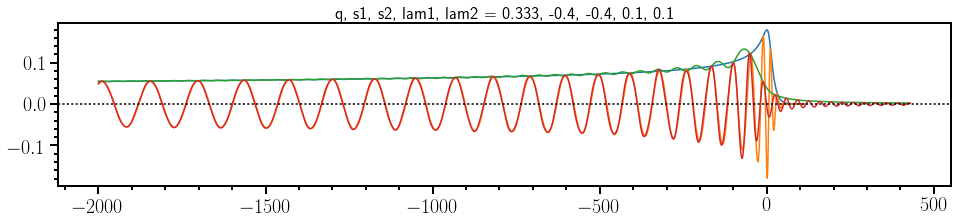

In [374]:
i = 0
p = params[i]
h = hlist[i]
print p

hsur_td = geometric_time_domain_waveform(sur, p, delta_t=10.)

h1 = h
h2 = hsur_td
# Often need really long window to get reliable overlap at low frequencies
t1i = -200000
t1f = -100000
taua = -500
taub = 500
taubest, phibest = hybrid.calculate_time_phase_shift(h1, h2, t1i, t1f, taua, taub)
print taubest, phibest
hsur_td.x += taubest
hsur_td.phase -= phibest

fig, ax = wave.plot_waveforms([h, hsur_td], xi=-2000, xf=1000, npoints=10000)
title = 'q, s1, s2, lam1, lam2 = {:.3}, {:.3}, {:.3}, {:.1f}, {:.1f}'.format(p[0], p[1], p[2], p[3], p[4])
ax.set_title(title)
ax.minorticks_on()

# Old junk

[ 0.33333333 -0.4        -0.4         0.1         0.1       ]
0.00077


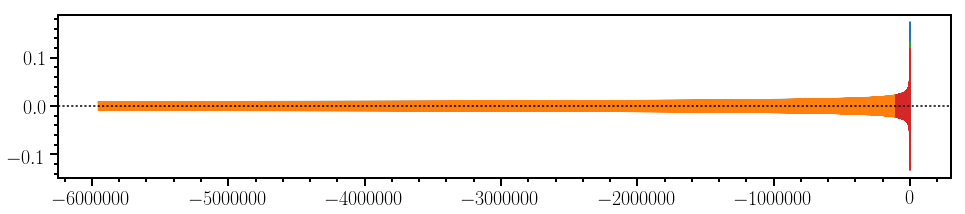

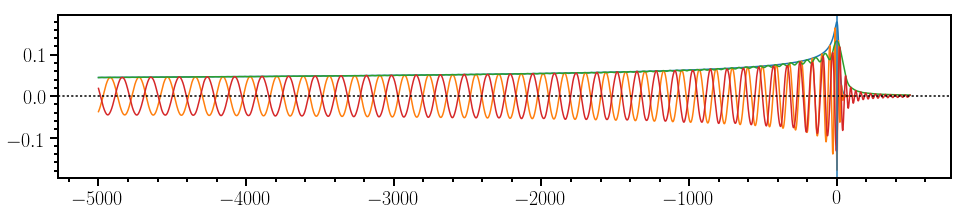

In [324]:
i = 0
p = params[i]
h = hlist[i]
print p

hsur_td = geometric_time_domain_waveform(sur, p, delta_t=10)

fig, ax = wave.plot_waveforms([h, hsur_td], npoints=100000)
ax.minorticks_on()
#ax.set_ylim(-0.3, 0.3)

fig, ax = wave.plot_waveforms([h, hsur_td], xi=-5000, xf=1000, npoints=10000)
ax.axvline(0)
ax.minorticks_on()
#ax.set_ylim(-0.3, 0.3)

[ 0.33333333 -0.4        -0.4         0.1         0.1       ]
0.00077
-5236.55558749 -5431.68351415


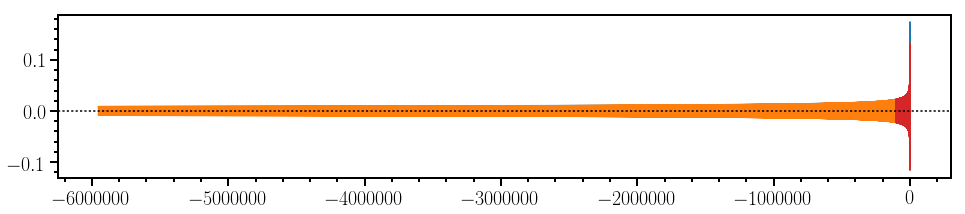

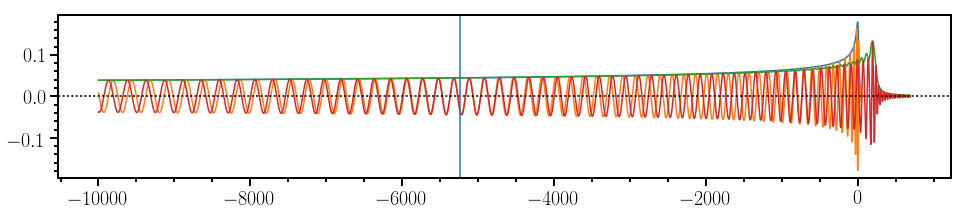

In [325]:
i = 0
p = params[i]
h = hlist[i]
print p

hsur_td = geometric_time_domain_waveform(sur, p, delta_t=10)

fref = 0.005
tref_h = window.interpolate_time_of_frequency(h)(fref)

tref_hsur = window.interpolate_time_of_frequency(hsur_td)(fref)
print tref_h, tref_hsur
hsur_td.x += tref_h - tref_hsur

hsur_td.phase += h.interpolate('phase')(tref_h) - hsur_td.interpolate('phase')(tref_h)

fig, ax = wave.plot_waveforms([h, hsur_td], npoints=100000)
ax.minorticks_on()

fig, ax = wave.plot_waveforms([h, hsur_td], xi=-10000, xf=1000, npoints=10000)
ax.axvline(tref_h)
ax.minorticks_on()